#### Imports

In [1]:
import PyPDF2
import csv
import re
import json
import os
import us
import numpy as np

In [2]:
YEAR = 2000

# OCR with Adobe Acrobat and extraction with fitz

In [3]:
from __future__ import print_function
from itertools import groupby
import fitz
import matplotlib.pyplot as plt

### Extract text

In [4]:
#open PDF which has gone through Adobe Acrobat OCR
doc = fitz.open("directory_{}_OCR.pdf".format(YEAR))
print('Number of pages:', len(doc))

Number of pages: 618


In [5]:
def text_to_rows(text, threshold):
    '''
    Splits a list of into rows.
    Inputs:
        Text: a list of tuple containing individual words and their positions
        Threshold: the distance between lines
    Outputs:
        List of list that represent rows.
    '''
    if text == []:
        return []
    text_by_row = []
    temp = []
    init_y = text[0][1] #y0
    i = 0
    while i < len(text):
        if (text[i][1] < init_y + threshold) and (text[i][1] > init_y - threshold):
            temp.append(text[i][4])
        else:
            text_by_row.append(temp)
            temp = [text[i][4]]
            init_y = int(text[i][1])
        i += 1
    text_by_row.append(temp)
    return text_by_row

In [6]:

def text_to_rows(text, threshold):
    '''
    Splits a list of into rows.
    Inputs:
        Text: a list of tuple containing individual words and their positions
        Threshold: the distance between lines
    Outputs:
        List of list that represent rows.
    '''
    if text == []:
        return []
    row_centroids = []
    text_by_row = []
    for word in text:
        i = 0
        newline = True
        while i < len(row_centroids):
            if (word[1] < row_centroids[i] + threshold) and (word[1] > row_centroids[i] - threshold):
                text_by_row[i] += [word[4]]
                newline = False
                break
            i += 1
        if newline:
            row_centroids.append(word[1])
            text_by_row.append([word[4]])
    return text_by_row

- Extract keys

In [7]:
abbr_keys = {}

In [8]:
#keys for treatment
pagen = 9
words = doc[pagen - 1].getText("words")
words = text_to_rows(words, 5)

In [9]:
for line in words[2:-6]:
    if line[0].isupper():
        abbr_keys[line[0]] = ' '.join(line[1:])

In [10]:
#keys for language
#None

In [11]:
abbr_keys['ML'] = 'Methadone/LAAM (Includes use for maintenance and/or detoxification. \
Check with facility for details.)'

In [12]:
abbr_keys

{'SA': 'Substance abuse treatment services',
 'MH': 'Mental health services',
 'MH-SA': 'Mix of mental health and substance abuse services',
 'GH': 'General health services',
 'TX': 'Substance abuse treatment',
 'DT': 'Detoxification',
 'ML': 'Methadone/LAAM (Includes use for maintenance and/or detoxification. Check with facility for details.)',
 'HH': 'Halfway house',
 'OP': 'Outpatient',
 'PH': 'Partial hospitalization/Day treatment',
 'RR': 'Non-hospital residential (24 hour)',
 'HI': 'Hospital inpatient',
 'AD': 'Adolescents',
 'DD': 'Dually diagnosed',
 'HV': 'Persons with HIV/ AIDS',
 'PW': 'Pregnant/postpartum women',
 'OW': "Other women's groups",
 'DU': 'DUI/DWI offenders',
 'CJ': 'Other criminal justice groups',
 'MD': 'Medicaid',
 'MC': 'Medicare',
 'PI': 'Private health insurance',
 'MI': 'Military insurance (e.g. VA, TRICARE)',
 'SS': 'Sliding fee scale (Fee is based on income and other factors.)',
 'OA': 'Other assistance'}

In [13]:
# add keys not included in front page but appeared elsewhere?

- Explore text

In [14]:
firstpagen = 17

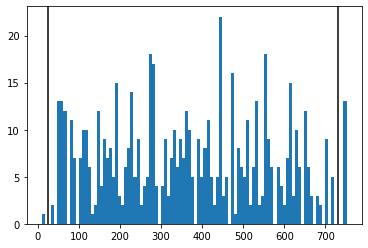

In [15]:
# - explore the page set up - 
# select a page
words = doc[firstpagen - 1].getText("words")
# check the y distribution to remove top and bottom crap...
y0s = [word[1] for word in words]
a = plt.hist(y0s, bins = 100)
plt.axvline(25, color='black')
plt.axvline(730, color='black')
#pages with the box of keys

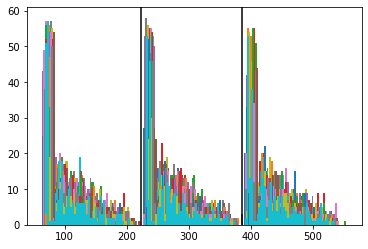

In [16]:
#pagen is odd
for pagen in range(100, 200, 2):
    words = doc[pagen - 1].getText("words")
    words = [word for word in words if (word[1] > 25) and (word[1] < 730)]
    x0s = [word[0] for word in words]
    a = plt.hist(x0s, bins = 150)

plt.axvline(223, color='black')
plt.axvline(385, color='black')

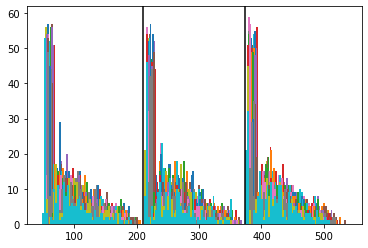

In [17]:
#pagen is even
for pagen in range(101, 200, 2):
    words = doc[pagen - 1].getText("words")
    words = [word for word in words if (word[1] > 25) and (word[1] < 730)]
    x0s = [word[0] for word in words]
    a = plt.hist(x0s, bins = 150)

plt.axvline(210, color='black')
plt.axvline(373, color='black')

- Read text from PDF

In [18]:
def get_words_in_box(page, pagen, ulim, blim, col1lim, col2lim, col1lim_odd, col2lim_odd):
    '''
    Extract words from each column of the PDF.
    '''
    page_txt = []
    pagen_is_even = (pagen%2 == 1)
    words = page.getText("words") 
    #cut off top and bottom
    words = [word for word in words if word[1] > ulim]
    words = [word for word in words if word[1] < blim]
    #get three columns
    if pagen_is_even:
        page_txt.append(text_to_rows([word for word in words if word[0] < col1lim], 5))
        page_txt.append(text_to_rows([word for word in words if ((word[0] > col1lim) and (word[0] < col2lim))], 5))
        page_txt.append(text_to_rows([word for word in words if word[0] > col2lim], 5))
        return page_txt
    page_txt.append(text_to_rows([word for word in words if word[0] < col1lim_odd], 5))
    page_txt.append(text_to_rows([word for word in words if ((word[0] > col1lim_odd) and (word[0] < col2lim_odd))], 5))
    page_txt.append(text_to_rows([word for word in words if word[0] > col2lim_odd], 5))
    return page_txt

In [19]:
#testing
#get_words_in_box(doc[firstpagen - 1], firstpagen, 35, 740, 210, 373, 223, 385)
#page with some blanck
#get_words_in_box(doc[24 - 1], 35, 740, 217, 388)

In [20]:
#run
data = []
for pagen in range(firstpagen, len(doc) + 1):
    data.append(get_words_in_box(doc[pagen-1], pagen, 35, 740, 210, 373, 223, 385))

In [21]:
#data[0][0]

# Write data into csv

- Checking + cleaning each part of data

In [750]:
def is_keys(line):
    '''
    Check if the line (list of list) is a list of keys
    '''
    #print("checking if line is keys...", line)
    if is_citystatezip(line) or is_contact(line) or is_address(line):
        return False
    line_cleaned = clean_keys(line)
    if not line_cleaned:
        return False
    if not any(x not in abbr_keys for x in line_cleaned):
        return True
    if line_cleaned[0] in abbr_keys:
        if len(line_cleaned) > 2 and line_cleaned[1] in abbr_keys:
            print("This line has more than 1 keys but not all, please check:", line)
        elif len(line_cleaned) > 3 and line_cleaned[2] in abbr_keys:
            print("This line has more than 1 keys but not all, please check:", line)
    return False

def clean_keys(line):
    keys_cleaned = []
    i = 0
    while i < len(line):
        key = line[i].replace('Dl/', 'DU').replace('l', 'I').replace("01'", 'OP').replace('1', 'I').replace('!', 'I')\
        .replace('\\V', 'W').replace('0', 'O').replace('I\\', 'A').replace('/\\', 'A')
        if (i < len(line) - 1):
            key_next = line[i + 1].replace('l', 'I').replace('1', 'I').replace('!', 'I')
        if (i < len(line) - 1) and ('M' in (key + line[i + 1])) and ('-SA' in (key + line[i + 1])) and len((key + line[i + 1])) < 8:
            keys_cleaned.append('MH-SA')
            i += 2
        elif (i < len(line) - 1) and (key == 'MI' or key == 'MI-') and (key_next == 'I' or key_next == 'I/'):
            keys_cleaned.append('MH')
            i += 2
        elif (i < len(line) - 1) and (key == 'PI' or key == 'PI-') and (key_next == 'I' or key_next == 'I/'):
            keys_cleaned.append('PH')
            i += 2
        elif (i < len(line) - 1) and key == 'M' and (key_next == 'I' or key_next == 'I/'):
            keys_cleaned.append('MI')
            i += 2
        elif (i < len(line) - 1) and key == 'M' and (key_next == 'L' or key_next == 'L/'):
            keys_cleaned.append('ML')
            i += 2
        elif (i < len(line) - 1) and key == 'D' and (key_next == 'T' or key_next == 'T/'):
            keys_cleaned.append('DT')
            i += 2
        elif key in abbr_keys:
            keys_cleaned.append(key)
            i += 1
        elif key.replace('O', 'D') in abbr_keys:
            keys_cleaned.append(key.replace('O', 'D'))
            i += 1
        elif key.replace('Q', 'D') in abbr_keys:
            keys_cleaned.append(key.replace('Q', 'D'))
            i += 1
        elif key.replace('Q', 'O') in abbr_keys:
            keys_cleaned.append(key.replace('Q', 'O'))
            i += 1
        elif ('M' in key) and ('-SA' in key) and len(key) < 8:
            keys_cleaned.append('MH-SA')
            i += 1
        elif key == 'C)':
            keys_cleaned.append('CJ')
            i += 1
        elif key == '[)D':
            keys_cleaned.append('DD')
            i += 1
        elif key == 'IIII':
            keys_cleaned.append('HH')
            i += 1
        elif key == 'T)_(':
            keys_cleaned.append('TX')
            i += 1
        elif key == "0I'":
            keys_cleaned.append('OP')
            i += 1
        elif key == 'T/' and line[i - 1] == 'O':
            keys_cleaned.append('DT')
            i += 1
        elif len(key) > 1:
            key_cleaned = "".join\
            (re.findall("[A-Za-z-!]+",\
                        key.replace('I-I', 'H').replace('I-J', 'H').replace('J-I', 'H')\
                        .replace('Y', 'V').replace('IV', 'HV').replace('AO', 'AD').replace('OT', 'DT')\
                        .replace('IH', 'HH').replace('DL', 'DU').replace('MJ', 'MI').upper()))
            if key_cleaned in abbr_keys:
                keys_cleaned.append(key_cleaned)
            elif key_cleaned.replace('O', 'D') in abbr_keys:
                keys_cleaned.append(key_cleaned.replace('O', 'D'))
            elif key_cleaned.replace('Q', 'D') in abbr_keys:
                keys_cleaned.append(key_cleaned.replace('Q', 'D'))
            elif key_cleaned.replace('Q', 'O') in abbr_keys:
                keys_cleaned.append(key_cleaned.replace('Q', 'O'))
            elif len(key_cleaned) == 3:
                if key_cleaned[:2] in abbr_keys:
                    keys_cleaned.append(key_cleaned[:2])
                elif key_cleaned[:2].replace('O', 'D').replace('Q', 'D').replace('Q', 'O') in abbr_keys:
                    keys_cleaned.append(key_cleaned[:2].replace('O', 'D').replace('Q', 'D').replace('Q', 'O'))
                elif key_cleaned[1:] in abbr_keys:
                    keys_cleaned.append(key_cleaned[1:])
                elif key_cleaned[1:].replace('O', 'D').replace('Q', 'D').replace('Q', 'O') in abbr_keys:
                    keys_cleaned.append(key_cleaned[1:].replace('O', 'D').replace('Q', 'D').replace('Q', 'O'))
                    
            elif len(key_cleaned) > 3 and len(key_cleaned)%2 == 0:
                keys_cleaned += [key_cleaned[i:i+2] for i in range(0, len(key_cleaned), 2)]
            elif key_cleaned != '':
                keys_cleaned.append(key_cleaned)
            i += 1
        else:
            if sum([len(key) for key in line])/len(line) < 3.5 and key.isupper() and key != 'I':
                print('Key might need to be combined at', key, line)
            i += 1
    return keys_cleaned

def write_keys(line):
    return '/'.join(clean_keys(line)) + '/'

In [719]:
# keys_test = [(['SA', '/TX', 'HI-I', '/', 'RR/', 'SS', 'OA'],['SA', 'TX', 'HH', 'RR', 'SS', 'OA']),
#              (['Ml', 'I-SA/', 'TX/', 'RR/', 'DD', 'OW', 'CJ/', 'OA'], ['MH-SA', 'TX', 'RR', 'DD', 'OW', 'CJ', 'OA']),
#              (['MI', 'I/', 'TX/', 'OP', 'I', 'DD', 'CJ', 'I', 'MD', 'MC', 'PI'], ['MH', 'TX', 'OP', 'DD', 'CJ', 'MD', 'MC', 'PI']),
#              (['SA', 'I', 'TX', '/OP/', 'AD', 'DD', 'DU', '/', 'PI', 'MI', '/'],['SA', 'TX', 'OP', 'AD', 'DD', 'DU', 'PI', 'MI']),
#              (['MI/OA', 'ss'],['MI', 'OA', 'SS']),
#              (['SA', 'I', 'TX', 'I', 'OP/', 'DD', 'DU', 'I', 'Pl', 'M', 'l/', 'SS'], ['SA', 'TX', 'OP', 'DD', 'DU', 'PI', 'MI', 'SS']),
#              (['SA', 'I', 'TX', 'DT', 'I', 'OP', 'RR/', 'HY', "ow';", 'MD'], ['SA', 'TX', 'DT', 'OP', 'RR', 'HV', 'OW', 'MD']),
#              (['Mil-SA', '/', 'TX', 'HI-I', '/', 'OP', 'RR/', 'DD', 'I-IV'], ['MH-SA', 'TX', 'HH', 'OP', 'RR', 'DD', 'HV']),
#              (['SA', '/', 'TX', '1-11-1', '/', 'OP', 'RR/', 'DD', 'OW', 'DU'], ['SA', 'TX', 'HH', 'OP', 'RR', 'DD', 'OW', 'DU']),
#              (['CJ', 'I', 'MD', 'MC', 'Pl', '/', 'SS', 'QA'], ['CJ', 'MD', 'MC', 'PI', 'SS', 'OA']),
#              (['IOA'], ['OA'])]

# for keys, right_keys in keys_test:
#     if is_keys(keys) and clean_keys(keys) == right_keys:
#         print('PASS')
#     else:
#         print('Wrong result at:', keys)

In [791]:
def is_citystatezip(line):
    if len(line[-1]) == 5 and line[-1].replace('I', '1').isnumeric():
        return True
    line = ''.join(line)
    i = 1
    while i < len(line) - 5:
        if (line[i] == '.' or line[i] == ',') and line[i + 2].replace('l', 'I').isupper() and \
        line[i + 4: i + 5].replace('I', '1').isnumeric():
            return True
        i += 1
    return False

def clean_citystatezip(line):
    i = 0
    while i < len(line):
        if ',' in line[i] or '.' in line[i]:
            break
        i += 1
    if i == len(line):
        return [' '.join(line[:-2]), line[-2], line[-1]]
    line = ' '.join(line[:i+1]) + ''.join(line[i+1:])
    split = re.split('[.,]', line)
    statezip = ''.join(split[1:])
    state = statezip[:2].replace('l', 'I')
    zipc = statezip[2:].replace('I', '1')
    return [split[0], state, zipc]

In [276]:
# citystatezip_tests = [
# ['Demopolis.', 'AL', '36732'],
# ['Birmingham,', 'AL', '35294'],
# ['Alexander', 'City,', 'AL', '350', 'I', '0'],
# ['Anniston.', 'AL', '3620', 'I'],
# ['El', 'Monte.CA', '91731'],
# ['Tuscaloosa', 'AL', '35404'], 
# ['Dt:nvt:r.', 'CO', '.80204'],
# ['Allegan.', 'Ml', '490', 'I', '0']]

# for t in citystatezip_tests:
#     print(is_citystatezip(t))
#     print(clean_citystatezip(t))

In [789]:
#['(205)', '216-0200'],
#['Intake:', '(205)', '216-0202'],
#['Hotlines:', '(888)', '950-4325', '(888)', '950HEAL']
#['6552x']
#['l-1otline:(626)', '359-9358']
#['(', '860)', '525-2181']

def is_contact(line):
    if ('Intake' in line[0]) or ('otlin' in line[0]) or ('lotlm' in line[0]):
        return True
    if len(line) > 1:
        if ('Intake' in line[1]) or ('otlin' in line[1]) or ('lotlm' in line[1]):
            return True
    if len(line[0]) > 4:
        if line[0][0] == '(' and line[0][4] == ')' and line[0][1:4].isnumeric():
            return True
        if line[0][:4].isnumeric() and line[0][4] == 'x':
            return True
    if len(line) > 1:
        line = ''.join(line)
        if line[0] == '(' and (line[4] == ')' or line[4] == 'J'):
            return True
    return False

def clean_contact(line):
    return ''.join(line).replace('I', '1').replace('(', ' (').strip()

In [759]:
address_indicators = ['P.O.', 'P.O', 'P.0.', 'P.0', 'Road', 'Highway', 'Route', 'Building', 'Street', 'Avenue', 'venue', 'Avenuc', 'venuc',\
                      'Suite', 'Suites', 'Suitc', 'Suitcs',\
                      'Drive', 'Drivc', 'Boulevard', 'Parkway', 'Lot',\
                      'Annex', 'Streets','Floor', 'Fl', 'Bldg', 'Rear', 'Room', 'Basement', 'Building,', 'Attn:'] 
name_indicators = ['Clinic', 'Medical', 'Inc', 'Health', 'Services', 'Treatment']

def is_address(line):
    if len(line) < 2:
        return False
    if is_contact(line):
        return False
    if (not line[0].replace('-', '').isnumeric()) and any(x in line for x in name_indicators):
        return False
    if line[0].replace('-', '').isnumeric() or any(x in line for x in address_indicators):
        return True
    return False

In [27]:
# #for testing
# for page_data in data:
#     for col in page_data:
#         for line in col:
#             for word in line:
#                 if word[0] == 'F' and word[-1].isnumeric() and word not in abbr_keys:
#                     print(line)

- Split data into MOUDs

In [615]:
def split_col_data(col_text):
    '''
    Split column data into list of MOUD facilities.
    '''
    col_text_splitted = []
    temp = []
    i = 0
    col_text = [text for text in col_text if any(char.isdigit() or char.isalpha() for char in ''.join(text))]
    while i < len(col_text) - 1:
        if is_keys(col_text[i]) and (not is_keys(col_text[i+1])):
            temp.append(col_text[i])
            col_text_splitted.append(temp)
            temp = []
        elif is_keys(col_text[i]) and (is_keys(col_text[i+1])):
            temp.append(col_text[i])
        else:
            if (not re.match(r'(?:[A-Z]+)$', ''.join(col_text[i]))):
                #if not keys and only upper characters, then ignore as name of city.
                temp.append(col_text[i])
        i += 1
    temp.append(col_text[-1])
    col_text_splitted.append(temp)
    return col_text_splitted

In [611]:
checkstring = ''.join([])
any(char.isdigit() or char.isalpha() for char in checkstring)

False

In [531]:
#split_col_data(data[6][0])

- Write data

In [585]:
def clean_col_data(col_text_splitted):
    '''
    Splits data into list of lists with
    name1, name2, address1, address2, city, state, zip, phone, keys
    '''
    data_holders = []
    for facil in col_text_splitted:
        if len(facil) < 2:
            print(facil)
        else:
            data_holder = []
            i = 0 #indicator of next line
            #name1
            data_holder.append(' '.join(facil[0])) 
            i += 1
            #name2
            if not is_address(facil[i]) and not is_citystatezip(facil[i]) and not is_contact(facil[i]): 
                data_holder.append(' '.join(facil[i])) 
                i += 1
            else:
                data_holder.append('') 
            #name3
            if not is_address(facil[i]) and not is_citystatezip(facil[i]) and not is_contact(facil[i]): 
                data_holder.append(' '.join(facil[i])) 
                i += 1
            else:
                data_holder.append('')         
            #address1
            if is_address(facil[i]) and not is_citystatezip(facil[i]):
                data_holder.append(' '.join(facil[i])) 
                i += 1
            else:
                data_holder.append('')
            #address2
            if not is_citystatezip(facil[i]) and not is_contact(facil[i]) and not is_keys(facil[i]):##
                data_holder.append(' '.join(facil[i])) 
                i += 1
            else:
                data_holder.append('')
            #address3
            if is_address(facil[i]) and not is_citystatezip(facil[i]):
                data_holder.append(' '.join(facil[i])) 
                i += 1
            else:
                data_holder.append('')
            #city, state, zip
            data_holder += clean_citystatezip(facil[i])
            i += 1
            #contact
            if is_contact(facil[i]):
                data_holder.append(clean_contact(facil[i]))
                i += 1
                while i < len(facil):
                    if is_contact(facil[i]):
                        data_holder[-1] += ' ' + clean_contact(facil[i])
                        i += 1
                    else:
                        break
            else:
                data_holder.append('')
            #website
            if facil[i][0].split('.')[-1] == 'org' or \
            facil[i][0].split('.')[0] == 'www' or facil[i][0].split('.')[-1] == 'com':
                data_holder.append(' '.join(facil[i]))
                i += 1
            else:
                data_holder.append('')
            #note
            if not is_keys(facil[i]):
                data_holder.append(' '.join(facil[i]))
                i += 1
            else:
                data_holder.append('')
            #keys
            data_holder.append('')
            for keys in facil[i:]:
                data_holder[-1] += write_keys(keys)
            data_holders.append(data_holder)
            print(".", end = '') #for each MOUD
    return data_holders

In [792]:
filename = "{}.csv".format(YEAR)
with open(filename, 'w', newline = '') as file:
    writer = csv.writer(file)
    writer.writerow(["Name1", "Name2", 'Name3', "Address1", "Address2", "Address3", \
                     "City", "State", "ZIP_Code", "Contact", "Website", "Note", "Keys"])

In [793]:
pagen = firstpagen
#pagen = 181

for page in data[:-6]: 
#for page in data[pagen - 17:pagen]:
    print("Page:", pagen, end = '')
    page_data_holders = []
    for col in page:
        if col != []:
            page_data_holders += clean_col_data(split_col_data(col))
            print(" Finished Col ", end = '')
    with open(filename, 'a', newline = '') as file:
        writer = csv.writer(file)
        writer.writerows(page_data_holders)
    pagen += 1
    print('')

Page: 17....... Finished Col ........ Finished Col ...... Finished Col 
Page: 18...... Finished Col ....... Finished Col ........ Finished Col 
Page: 19....... Finished Col ...... Finished Col ...... Finished Col 
Page: 20... Finished Col 
Page: 21Key might need to be combined at Y ['TCC', 'Y', 'TCMHC']
Key might need to be combined at Y ['TCC', 'Y', 'TCMHC']
....... Finished Col Key might need to be combined at A ['Dena', 'A', 'Coy']
Key might need to be combined at A ['Dena', 'A', 'Coy']
....... Finished Col ....... Finished Col 
Page: 22....... Finished Col ....... Finished Col ....... Finished Col 
Page: 23....... Finished Col ........ Finished Col .... Finished Col 
Page: 24...... Finished Col ....... Finished Col ....... Finished Col 
Page: 25........ Finished Col ....... Finished Col ....... Finished Col 
Page: 26....... Finished Col ........ Finished Col ....... Finished Col 
Page: 27....... Finished Col ........ Finished Col ........ Finished Col 
Page: 28......... Finished Co

IndexError: list index out of range

In [782]:
#check error data
pagen = 181
col = 3
split_col_data(data[pagen - 17][col - 1])#[5]

[[['Alcohol', 'Impaired', 'Motorists', 'Program'],
  ['(AIM)'],
  ['505', 'North', 'Center', 'Street'],
  ['Bloomington.', 'IL', '61701'],
  ['(309)', '829-9384'],
  ['SA', 'I', 'TX', 'I', 'OP/', 'DU', 'CJ', 'I', 'SS', 'OA']],
 [['Chestnut', 'Health', 'Svstems', 'Inc'],
  ['Adolescent', 'Chemical', 'Dependency', 'Sens'],
  ['702', 'West', 'Chestnut', 'Strcet'],
  ['Bloomington,', 'IL', '6170', 'I'],
  ['(309)', '827-6026'],
  ['www.chcstnut.org'],
  ['Ml-I-SA', 'I', 'TX/', 'OP', 'PH', 'RR/', 'AD', 'I', 'MD'],
  ['Pl', 'Ml/', 'OA']],
 [['Chestnut', 'Health', 'Svstems', 'Inc'],
  ['Lighthousc', 'Adult.'],
  ['I', '003', 'Martm', 'Luther', 'King', 'Jr', 'Drive'],
  ['Bloomington.', 'IL', '6170', 'I'],
  ['(309)', '827-6026'],
  ['www.chestnut.com'],
  ['MH-SA', 'I', 'TX', 'DT', 'HH', '/', 'OP', 'PH', 'RR/'],
  ['OW', 'DU', 'I', 'MD', 'Pl/', 'OA']],
 [['Countcrmeasurcs', 'Im:'],
  ['I', 'IO', 'North', 'Centcr', 'Street'],
  ['Bloomington.', 'IL', '61701'],
  ['(309)', '827-0818'],
  ['SA/'

In [742]:
is_keys(['CJSSOA'])

True

In [732]:
data[pagen - 17][col - 1].index(['MI-1-S/\\', '/', 'TX', 'OT/', 'OP', 'PH', 'HI/', 'DD'])

6

In [622]:
'OT' in abbr_keys

False

In [715]:
clean_keys(['Ml-', 'I/', 'TX/', 'OP/', 'OU/', 'Pl'])

['MH', 'TX', 'OP', 'OU', 'PI']

- Rewrite data in problem pages

In [781]:
# pagen = 181
# col = 3
# data[pagen - 17][col - 1][19] = ["www.chestnut.com"]

In [768]:
# pagen = 53
# col = 3
# split_col_data(data[pagen - 17][col - 1])

# pagen = 187
# col = 1
# data[pagen - 17][col - 1][6] = ['MH-SA', '/', 'TX', 'OT/', 'OP', 'PH', 'HI/', 'DD']
# data[pagen - 17][col - 1][-1] = ['CJSSOA']

# pagen = 184
# col = 3
# data[pagen - 17][col - 1][35] = ['OW', 'CJ', 'I', 'MD', 'Pl/', 'SS', 'OA']

# pagen = 182
# col = 1
# data[pagen - 17][col - 1][4] = ['(847)', '478-8332']
# data[pagen - 17][col - 1][11] = ['MH', 'I', '/TX', 'I', 'OP/', 'AD', 'DD', 'PW', 'OW', 'CJ']
# data[pagen - 17][col - 1][12] = ["MD", 'Pl', 'Ml/', 'SS', 'OA']
# data[pagen - 17][col - 1][18] = ["MH", 'TX', 'I', 'OP/', 'AD', 'DD', 'DU', 'CJ', 'I', 'Pl/']
# data[pagen - 17][col - 1][26] = ['TX/', 'OP/', 'AD', 'DD', 'PW', 'CJ/', "MD", 'MC']
# data[pagen - 17][col - 1][32] = ['Hotline', '(800)', '848-4270']
# data[pagen - 17][col - 1][33] = ['MH', 'I', 'TX', '/', 'OP/', 'DD', 'I-IV', 'PW', 'DU', '/']
# data[pagen - 17][col - 1][34] = ['MD', 'Pl', "MI", '/', 'SS', 'OA']
# data[pagen - 17][col - 1][42] = ['1-11-1/0A']
# data[pagen - 17][col - 1][-2] = ['SA', '!', 'TX', '/', 'OP', 'I', 'OW', 'DU', 'CJ/', 'MC', 'Pl', '/']
# col = 2
# data[pagen - 17][col - 1][29] = ['SA', 'I', 'TX/', 'OP/', 'DD', 'DU', 'CJ', '/', 'Pl', '/', 'OA']

# pagen = 181
# col = 3
# data[pagen - 17][col - 1][20] = ['MH-SA', 'I', 'TX', 'DT', 'HH', '/', 'OP', 'PH', 'RR/']

# pagen = 180
# col = 2
# data[pagen - 17][col - 1][1] = ['Detox/Rehab/OP/IOP/Prev/DUI/MIS']

# pagen = 178 
# col = 2
# data[pagen - 17][col - 1][31] = ['DU', 'MC', 'Pl', 'Ml', '/', 'OA']

# pagen = 121
# col = 1
# data[pagen - 17][col - 1][51] = ['Ml-I-SA/', 'TX/', 'HI', '/', 'DD', 'HY', 'PW', 'OW']

# pagen = 124
# col = 1
# data[pagen - 17][col - 1][14] = ['CMHA']

[[['Gold', 'Coast', 'Counseling', 'Center'],
  ['28052', 'Camino', 'Capistrano'],
  ['Suite214'],
  ['Laguna', 'Niguel.', 'CA', '92677'],
  ['(949)', '347-8885'],
  ['SA', 'I', 'TX', 'I', 'OP', 'I', 'DU', 'CJ', 'I', 'OA']],
 [['Garv', 'Center'],
  ['34', 'I', '°Hillcrest', 'Street'],
  ['La', 'Habra.', 'CA', '9063', 'I'],
  ['(562)', '691-3263'],
  ['SA', 'I', 'TX', '/', 'OP', 'I', 'SS']],
 [['Familv', 'Treatment', 'Institute'],
  ['Cocaine', 'Stimulant', 'Recovery', 'Program'],
  ['4225', 'Executive', 'Square'],
  ['Suite', '1110'],
  ['La', 'Jolla.', 'CA', '92037'],
  ['(858)', '546-9255'],
  ['Mil-SA/', 'TX/', 'OP/', 'Pl/', 'SS']],
 [['Practical', 'Recoverv', 'Services'],
  ['8950', 'Villa', 'La', 'Jolla', 'Drive'],
  ['Suite', '1130'],
  ['La', 'Jolla,', 'CA', '92037'],
  ['(858)', '453-4777'],
  ['Intake:', '(858)', '455-0042'],
  ['SA', 'I', 'TX', 'I', 'OP', 'I', 'OW', 'Dli', 'CJ', 'I', ':VIC', 'Pl'],
  ['Ml']],
 [['Riverside', 'Recoverv', 'Resources'],
  ['Communitv', 'Rccov:crv

In [626]:
# pagen = 96
# col = 3
# data[pagen - 17][col - 1][15] = ['SA/', 'TX', 'OT', 'ML/', 'OP/', 'MD/', 'SS', 'OA']

# pagen = 83
# col = 1
# data[pagen - 17][col - 1][26] = ['SA', 'I', 'TX', 'DT', '/', "01'", '/', 'PW', 'OW', 'CJ', 'MD']
# data[pagen - 17][col - 1][27] = []

# pagen = 79
# col = 1
# data[pagen - 17][col - 1][28] = ['SA', 'I', 'TX', 'I', 'OP', 'RR/', 'DD', 'HV', 'PW', 'OW']

# pagen = 93
# col = 2
# data[pagen - 17][col - 1][33] = ['Stockton,', 'CA', '95202']

# pagen = 52
# col = 1
# data[pagen - 17][col - 1][47] = ['SA', 'I', 'TX', 'I', 'OP', 'PH', '/', 'AD', 'CJ/', 'SS', 'OA']

# pagen = 55
# col = 1
# data[pagen - 17][col - 1][21] = ['SA', '/', 'TX', 'DT/', 'RR', '/', 'AD/', 'SS', 'OA']

# pagen = 172
# col = 2
# data[pagen - 17][col - 1][50] = ['MH-SA', '/', 'TX', 'DT', 'ML/', 'OP/', 'DU/', 'Ml', '/']

# pagen = 168
# col = 1
# data[pagen - 17][col - 1][26] = ['SA', 'I', 'TX', 'DT', '/', 'OP', 'RR/', 'DD', 'HV', 'OW']

# pagen = 161
# col = 2
# data[pagen - 17][col - 1][25] = ['MH', '/', 'TX', 'DT', '/', 'OP', 'PH', 'HI', 'DD/', 'MD']

# pagen = 159
# col = 1
# data[pagen - 17][col - 1][21] = ['SA', 'I', 'TX/', 'RR/', 'DD/', 'MD', 'MC', 'Pl', 'Ml/']

# pagen = 139
# col = 3
# data[pagen - 17][col - 1][32] = ['SA', '/', 'TX', 'DT', '/', 'RR/', 'MD', 'PI', 'SS', 'OA']

In [296]:
# pagen = 127
# col = 3
# data[pagen - 17][col - 1][51] = ['SA', '/', 'TX', '/OP/', 'AD', 'OW', 'CJ', 'I', 'MD', 'MC']

# pagen = 122
# col = 3
# data[pagen - 17][col - 1][23] = ['MH', '/', 'TX', 'OT', 'ML/', 'HI', '/', 'AD', 'DD/', 'MD']

# pagen = 115
# col = 1
# data[pagen - 17][col - 1][26] = ['MC', 'Pl', 'MI', '/', 'SS', 'OA']
# data[pagen - 17][col - 1][-22] = ['Ml/', 'SS', 'OA']
# data[pagen - 17][col - 1][-13] = ['MC', 'Pl', "MI", '/', 'SS']

# pagen = 119
# col = 3
# data[pagen - 17][col - 1][-16] = ['DD', 'HY', 'OW', '/', 'MC', 'PI', 'Ml/', 'SS', 'OA']\

# pagen = 44
# col = 3
# data[pagen - 17][col - 1][25] = ['Intake:', '(310)207-4322']

# pagen = 82
# col = 3
# data[pagen - 17][col - 1][-9] = ['(415)', '241-11', '70']

# pagen = 121
# col = 2
# data[pagen - 17][col - 1][-8] = ['OW', 'CJ', 'I', 'MD', 'MC', 'Pl', 'Ml', '/', 'SS', 'OA']

In [171]:
# pagen = 23
# col = 3
# data[pagen - 17][col - 1][10] = ['Wasilla,', 'AK', '99654']

# pagen = 45
# col = 1
# data[pagen - 17][col - 1][-12] = ['Covina.', 'CA', '91722']

# pagen = 59
# col = 1
# data[pagen - 17][col - 1][-5] = ['Los', 'Angeles.', 'CA', '90017']
# data[pagen - 17][col - 1][-13] = ['Los', 'Angeles.', 'CA', '90007']

# pagen = 74
# col = 1
# data[pagen - 17][col - 1][-10] = ['Rio', 'Vista,', 'CA', '94571']

# pagen = 107
# col = 1
# data[pagen - 17][col - 1][26] = ['SA/', 'TX/', 'OP', "HH", '/', 'AD', 'PW', 'OW', 'CJ/']

# pagen = 63
# col = 1
# data[pagen - 17][col - 1][21] = ['TX', 'OP', 'DU', 'OA']

# pagen = 67 
# col = 2
# data[pagen - 17][col - 1][16] = ['SA', 'TX', 'OP', 'PH', 'RR', 'DD', 'HV', 'OW']

# pagen = 78 
# col = 3
# data[pagen - 17][col - 1][-1] = ['SA', 'I', 'TX/', 'OP/', 'HY', 'OW', 'CJ', 'I', 'SS', 'OA']

# pagen = 97
# col = 2
# data[pagen - 17][col - 1][-14] = ['HV', 'PW', 'CJ', 'I', 'MD', 'MC', 'PI', 'MI']

# pagen = 100
# col = 1
# data[pagen - 17][col - 1][-18] = ['GH', '/', 'TX', 'DT', 'HH', '/', 'OP', 'PH', 'RR', 'HI', 'DD']

# pagen = 103
# col = 1
# data[pagen - 17][col - 1][-13] = ['SA/', 'TX', 'i', 'OP/', 'AD', 'HV', 'PW', 'OW', 'DU']
# data[pagen - 17][col - 1][-7] = ['SA', '/', 'TX', '/', 'OP/', 'DL', '/', 'SS', 'OA']

# Clean final data
- Replaced "A venue" with "A venue" in Address1
- Split ZIP code into two if in the format "35294-0018"
- To-do:
    - Clean up the wrong letters/numbers in address

In [794]:
import pandas as pd

In [795]:
df = pd.read_csv("{}.csv".format(YEAR))
df

,Name1,Name2,Name3,Address1,Address2,Address3,City,State,ZIP_Code,Contact,Website,Note,Keys
0,Lighthouse of Tallapoosa County Inc,Substance Abuse Re)rnbilitation Program,NaN,36 Franklin Street,NaN,NaN,Alexander City,AL,35010,(205)234-4894 Hotline: (800)762-3790,NaN,NaN,SA/TX/HH/RR/SS/OA/
1,Anniston fellowship House Inc,NaN,NaN,106 East 22nd Street,NaN,NaN,Anniston,AL,36201,(256)236-7229,NaN,NaN,SA/TX/HH/RR/CJ/SS/OA/
2,Calhoun/Cleburne Mental Health Center,New Directions,NaN,407 South Nobcl Street,NaN,NaN,Anniston,AL,36201,(256)236-8003 Hotline: (256)236-3403,NaN,NaN,SA/TX/OP/AD/DD/DU/PI/MI/SS/
3,Alcoholism Recovery Services Inc,NaN,NaN,2701 Jefferson Avenue SW,NaN,NaN,Birmingham,AL,35211,(205)923-6552,NaN,NaN,SA/TX/DT/OP/RR/HV/OW/MD/SS/OA/
4,Aletheia I-louse,NaN,NaN,201 Finley Avenue West,NaN,NaN,Birmingham,AL,35204,(205)324-6502,NaN,NaN,SA/TX/HH/OP/RR/PW/MD/PI/MI/OA/
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3918,Scott Bayrach Limited,NaN,NaN,925 North Milwaukee Avenue,Suite 1016,NaN,Wheeling,IL,60090,(847)459-8879 Hotline: (888)384-2687,NaN,NaN,SA/TX/OP/DU/SS/
3919,Behavioral Health Services of,Central DuPage Hospital,NaN,27 West 350 High Lake Road,NaN,NaN,Winfield,IL,60190,(630)653-4000 Hotline: (630)653-4000,NaN,NaN,MH-SA/TX/DT/OP/PH/RR/HI/AD/DD/HV/OW/MD/MC/PI/M...
3920,Cornell Interventions Inc,All Ale/Substance Abuse Progs on Site,NaN,2221 West 64th Street,NaN,NaN,Woodridge,IL,60517,(630)968-6477,NaN,NaN,SA/TX/OP/RR/AD/DD/CJ/MD/MC/PI/MI/SS/
3921,New Visions Counseling Services Inc,NaN,NaN,8263 Janes A venue,Suite I,NaN,Woodridge,IL,60517,(630)910-1100,NaN,NaN,SA/TX/OP/DU/CJ/PI/OA/


In [796]:
#check if all state names are right
for index, row in df.iterrows():
    #print(row)
    if len(row[7])!=2:
        print(row)

Name1           Consolidated Substance Abuse
Name2                      Counseling Center
Name3                      Marine Corps Base
Address1                                 NaN
Address2                                 NaN
Address3                                 NaN
City                                     NaN
State                               Building
ZIP_Code                               16105
Contact                                  NaN
Website                                  NaN
Note                Camp Pendleton, CA 92055
Keys        O/-/IN/TA/KE/O/-/SA/TX/OP/PH/OA/
Name: 493, dtype: object
Name1        Transcultural Health Development
Name2                                     NaN
Name3                                     NaN
Address1    I 17 East Harry Bridges Boulevard
Address2               Wilmington. CA. .90744
Address3                                  NaN
City                                      NaN
State                                   (310)
ZIP_Code              

In [50]:
#check if all zip codes are correct
df.dtypes

Name1       object
Name2       object
Name3       object
Address1    object
Address2    object
Address3    object
City        object
State       object
ZIP_Code     int64
Contact     object
Website     object
Note        object
Keys        object
dtype: object

- Correct in Pandas

In [51]:
#if address 1 and 2 should actually be one line...
for index, row in df.iterrows():
    if row[0].split()[-1] == 'and':
        if pd.isnull(row[1]):
            print(index)
        else:
            df.at[index, 'Name1'] = row[0] + ' ' + row[1]
            df.at[index, 'Name2'] = ''

In [ ]:
#replace a venue with avenue

In [52]:
# def split_zip(zipc):
#     if '-' in zipc:
#         return zipc.split('-')
#     return [zipc, None]
# #split zip-code if zip code is in the format xxxxx-xxxx
# df['zip1'] = [split_zip(zipc)[0] for zipc in df['ZIP_Code']]
# df['zip2'] = [split_zip(zipc)[1] for zipc in df['ZIP_Code']]

In [53]:
df.to_csv('{}_c.csv'.format(YEAR), index = False)

## Summary stats

- Check keys

In [54]:
df = pd.read_csv('{}_c.csv'.format(YEAR))

In [57]:
Methadone_keys = []
for key, val in abbr_keys.items():
    if val:
        if ('Methadone' in val) or ('methadone' in val):
            Methadone_keys.append(key)
            print(key, val)

MM Methadone maintenance (facility may also use buprenorphine in maintenance)
DM Methadone detoxification (facility may also use buprenorphine in detoxification)


In [58]:
Buprenorphine_keys = []
for key, val in abbr_keys.items():
    if val:
        if ('Buprenorphine' in val) or ("buprenorphine" in val):
            Buprenorphine_keys.append(key)
            print(key, val)

MM Methadone maintenance (facility may also use buprenorphine in maintenance)
DM Methadone detoxification (facility may also use buprenorphine in detoxification)


In [59]:
Naltrexone_keys = []
for key, val in abbr_keys.items():
    if val:
        if ('Naltrexone' in val) or ('naltrexone' in val):
            Naltrexone_keys.append(key)
            print(key, val)

- Count keys

In [60]:
def count_key(df, key):
    '''
    Count the number MOUD with a certain key
    '''
    df[key] = df.apply(lambda row: key in row['Keys'].split('/'), axis = 1)
    return len(df[df[key] == True])

In [61]:
len(df)

11060

In [62]:
labels = []
MOUD_numbers = []

In [63]:
for key in Methadone_keys:
    n_MOUD_with_key = count_key(df, key)
    print(key, ":", abbr_keys[key], '\t\t', n_MOUD_with_key)
    labels.append(abbr_keys[key] + '(' + key + ')')
    MOUD_numbers.append(n_MOUD_with_key)

MM : Methadone maintenance (facility may also use buprenorphine in maintenance) 		 925
DM : Methadone detoxification (facility may also use buprenorphine in detoxification) 		 664


In [64]:
for key in Buprenorphine_keys:
    n_MOUD_with_key = count_key(df, key)
    print(key, ":", abbr_keys[key], '\t\t', n_MOUD_with_key)
    if (abbr_keys[key] + '(' + key + ')') not in labels:
        labels.append(abbr_keys[key] + '(' + key + ')')
        MOUD_numbers.append(n_MOUD_with_key)

MM : Methadone maintenance (facility may also use buprenorphine in maintenance) 		 925
DM : Methadone detoxification (facility may also use buprenorphine in detoxification) 		 664


In [65]:
for key in Naltrexone_keys:
    n_MOUD_with_key = count_key(df, key)
    print(key, ":", abbr_keys[key], '\t\t', n_MOUD_with_key)
    if (abbr_keys[key] + '(' + key + ')') not in labels:
        labels.append(abbr_keys[key] + '(' + key + ')')
        MOUD_numbers.append(n_MOUD_with_key)

In [66]:
labels

['Methadone maintenance (facility may also use buprenorphine in maintenance)(MM)',
 'Methadone detoxification (facility may also use buprenorphine in detoxification)(DM)']

In [67]:
MOUD_numbers

[925, 664]

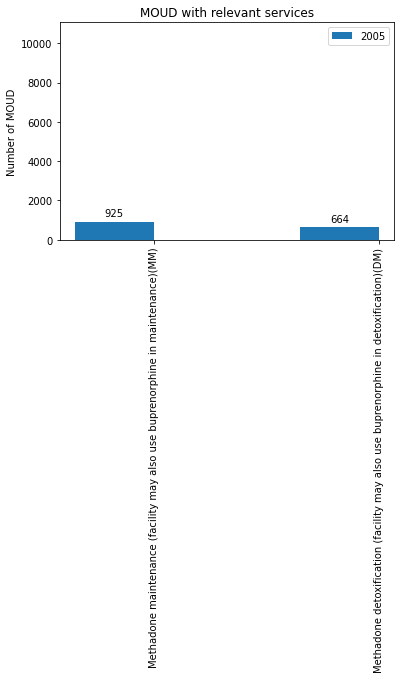

In [68]:
#barchart: https://matplotlib.org/3.3.0/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, MOUD_numbers, width, label=str(YEAR))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of MOUD')
ax.set_title('MOUD with relevant services')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)

plt.ylim(0, len(df))
plt.xticks(rotation=90)
plt.savefig('{}_stats.png'.format(YEAR), bbox_inches = 'tight')